# Project Documentation: German Credit Risk Analysis using XGBoost

## Project Overview
This project represents my initial attempt at applying machine learning techniques to a real-world dataset. The primary objective is to analyze the German Credit Risk dataset by developing a predictive model using the XGBoost classifier (`XGBClassifier`). The goal is to build a model that can accurately classify credit risk based on various input features.


1. Problem Definition

    The goal of this project is to develop a machine learning model capable of predicting the credit risk of individuals using the German Credit dataset. The target is to identify whether a customer presents a good or bad credit risk based on various personal and financial features.

    We apply the XGBoost classifier, a high-performance gradient boosting method, and evaluate the model using accuracy, precision, recall, F1-score, and ROC AUC metrics.


2. Importing Libraries

In [1]:
!pip install xgboost
!pip install shap
import pandas as pd
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


3. Data Loading and Preprocessing

   We begin by loading the dataset and performing basic preprocessing, including:
    - Handling missing values
    - Encoding categorical features
    - Splitting the data into training and validation sets

In [2]:
df = pd.read_csv(r"C:\Users\maksi\OneDrive\Desktop\german_credit_data.csv", index_col = 0)



categorical_cols = [cols for cols in df.columns 
             if df[cols].dtype == "object" and cols != 'Risk']
num_cols = [cols for cols in df.columns
            if df[cols].dtype == "int" or df[cols].dtype == "float" ]


X = df.drop('Risk', axis=1)
y = df['Risk'].map({'good':1,'bad':0})
 

X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size =0.8, test_size = 0.2,random_state = 42) 


4.  Pipeline Construction

    We define preprocessing pipelines for both numerical and categorical features and combine them with the XGBoost classifier in a full pipeline.

In [3]:
categorical_transformer = Pipeline(steps =[
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("onehotencode",OneHotEncoder(handle_unknown='ignore'))
])
numerical_transformer = SimpleImputer(strategy = "mean")
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numerical_transformer,num_cols)
    ])


my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', XGBClassifier(random_state = 42))
                             ])

5. Hyperparameter Tuning

    We conduct a GridSearchCV to identify the optimal hyperparameters for the model. The search is conducted using 3-fold cross-validation to speed up the process.

In [4]:
param_grid = {
    'model__n_estimators':[200,500,800],
    'model__learning_rate':[0.1,0.05,0.01],
    'model__max_depth':[10,20,30],
    'model__reg_alpha':[0, 0.1, 1],
    'model__reg_lambda':[1, 5, 10],
    'model__scale_pos_weight':[0.2,0.43,1]
}
gridsearch = GridSearchCV(
    estimator = my_pipeline,
    param_grid = param_grid,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    scoring = 'accuracy',
    n_jobs = 3,
    verbose = 1
)
gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencode',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Housing',
                                                                          'Saving '
                                                                          'accounts',
                                                                          'Checking '
                                                                          'account',
                                                                          'Purpose']),
                                                                        ('num',
                                                                         Simpl...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=3,
             param_grid={'model__learning_rate': [0.1, 0.05, 0.01],
                         'model__max_depth': [10, 20, 30],
                         'model__n_estimators': [200, 500, 800],
                         'model__reg_alpha': [0, 0.1, 1],
                         'model__reg_lambda': [1, 5, 10],
                         'model__scale_pos_weight': [0.2, 0.43, 1]},
             scoring='accuracy', verbose=1)

6.  Model Evaluation
    
    We evaluate the model performance on the validation set using various classification metrics.

In [5]:
predictions = gridsearch.predict(X_valid)
proba = gridsearch.predict_proba(X_valid)[:, 1]
print("Accuracy:", accuracy_score(y_valid, predictions))
print("Precision:", precision_score(y_valid, predictions))
print("Recall:", recall_score(y_valid, predictions))
print("F1-score:", f1_score(y_valid, predictions))
print("ROC AUC:", roc_auc_score(y_valid, proba))
print(gridsearch.best_params_)

Accuracy: 0.71
Precision: 0.7150259067357513
Recall: 0.9787234042553191
F1-score: 0.8263473053892215
ROC AUC: 0.6465921384781824
{'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__reg_alpha': 0.1, 'model__reg_lambda': 10, 'model__scale_pos_weight': 1}


7.  Recursive Hyperparameter Refinement

    We use a recursive tuning function to fine-tune hyperparameters further based on previous best values.


In [6]:
def param_searcher(learning_rate,
                   max_depth,
                   n_estimators,
                   model__reg_alpha,
                   model__reg_lambda,
                   model__scale_pos_weight,
                   X_train,
                   y_train,
                   X_valid,
                   y_valid,
                   best_score,
                   tolerance = 0.01):
    
        my_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', XGBClassifier(random_state=42))
        ])
        
    
        param_grid_new = {
        'model__n_estimators':[max(1, n_estimators - 50),n_estimators,n_estimators+50],
        'model__learning_rate':[max(0.001, learning_rate - 0.005),learning_rate,learning_rate+0.005],
        'model__max_depth':[max(1, max_depth - 5),max_depth,max_depth+5],
        'model__reg_alpha':[max(0.05,model__reg_alpha-0.05),model__reg_alpha,model__reg_alpha+0.05],
        'model__reg_lambda':[max(1,model__reg_lambda-1),model__reg_lambda,model__reg_lambda+1],
        'model__scale_pos_weight':[max(0.1, model__scale_pos_weight - 0.1), model__scale_pos_weight, model__scale_pos_weight + 0.1]
        }
        
        gridsearch = GridSearchCV(
        estimator = my_pipeline,
        param_grid = param_grid_new,
        cv=KFold(n_splits=3, shuffle=True, random_state=42),
        scoring = 'accuracy',
        n_jobs = 3,
        verbose = 1
        )
        gridsearch.fit(X_train,y_train)
        predictions = gridsearch.predict(X_valid)
        score = accuracy_score(y_valid, predictions)
        if score - best_score < tolerance:
            return {
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'n_estimators': n_estimators,
                'best_score': best_score,
                'reg_alpha': model__reg_alpha,
                'reg_lambda':model__reg_lambda,
                'scale_pos_weight':model__scale_pos_weight
            }
        
        return param_searcher(gridsearch.best_params_['model__learning_rate'],
                              gridsearch.best_params_['model__max_depth'],
                              gridsearch.best_params_['model__n_estimators'],
                              gridsearch.best_params_['model__reg_alpha'],
                              gridsearch.best_params_['model__reg_lambda'],
                              gridsearch.best_params_['model__scale_pos_weight'],
                              X_train,
                              y_train,
                              X_valid,
                              y_valid,
                               score)
best_params = param_searcher(gridsearch.best_params_['model__learning_rate'],
               gridsearch.best_params_['model__max_depth'],
               gridsearch.best_params_['model__n_estimators'],
               gridsearch.best_params_['model__reg_alpha'],
               gridsearch.best_params_['model__reg_lambda'],
               gridsearch.best_params_['model__scale_pos_weight'],
               X_train,
               y_train,
               X_valid,
               y_valid,
               accuracy_score(y_valid, predictions))
final_model = XGBClassifier(random_state=42,
                            learning_rate=best_params['learning_rate'],
                            max_depth=best_params['max_depth'],
                            n_estimators=best_params['n_estimators'],
                            reg_alpha=best_params['reg_alpha'],
                            reg_lambda=best_params['reg_lambda'],
                            scale_pos_weight=best_params['scale_pos_weight']
                           )
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', final_model)
                             ])
my_pipeline.fit(X_train,y_train)
predictions = my_pipeline.predict(X_valid)
proba = my_pipeline.predict_proba(X_valid)[:, 1]
print("Accuracy:", accuracy_score(y_valid, predictions))
print("Precision:", precision_score(y_valid, predictions))
print("Recall:", recall_score(y_valid, predictions))
print("F1-score:", f1_score(y_valid, predictions))
print("ROC AUC:", roc_auc_score(y_valid, proba))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Accuracy: 0.71
Precision: 0.7150259067357513
Recall: 0.9787234042553191
F1-score: 0.8263473053892215
ROC AUC: 0.6465921384781824


8.  Feature Importance

    We analyze which features contributed most to the model's decisions.

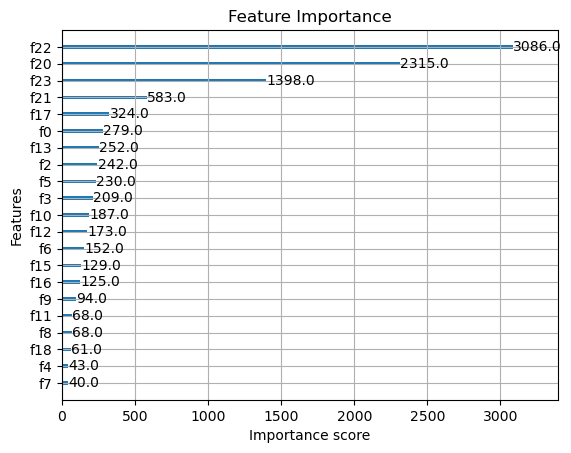

                      Feature  Importance
3                 Housing_own    0.132823
23                   Duration    0.068701
10  Checking account_moderate    0.061015
17           Purpose_radio/TV    0.056930
4                Housing_rent    0.056298
13                Purpose_car    0.055779
8        Saving accounts_rich    0.053238
2                Housing_free    0.048921
21                        Job    0.048777
20                        Age    0.043626


In [8]:
feature_names_cat = my_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehotencode'].get_feature_names_out(categorical_cols)
feature_names_num = num_cols 
feature_names = list(feature_names_cat) + list(feature_names_num)
xgb_model = my_pipeline.named_steps['model']
xgb.plot_importance(xgb_model, importance_type='weight')
plt.title("Feature Importance")
plt.show()
importances = xgb_model.feature_importances_
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_importance.sort_values(by='Importance', ascending=False, inplace=True)
print(df_importance.head(10))

9. SHAP Interpretation

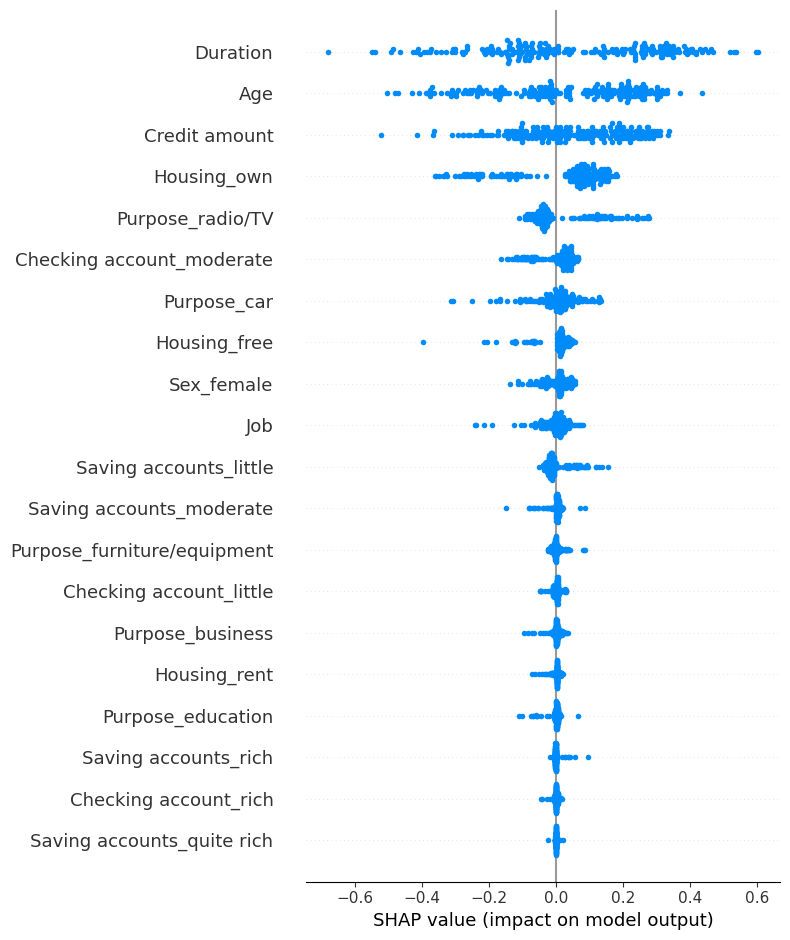

In [9]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(preprocessor.transform(X_valid))

shap.summary_plot(shap_values, feature_names=feature_names)


10. Conclusion

    The final model achieved the following performance:

    - Accuracy: 0.71
    - Precision: 0.715
    - Recall: 0.979
    - F1-score: 0.826
    - ROC AUC: 0.647

    The model successfully identifies high-risk clients with high recall, although the AUC indicates potential for further calibration or feature engineering.
